## Machine Learning and Statistics Project 2020
***


The aim of this project is to create a web service that uses machine learning to make predictions based on the data set 'powerproduction'. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. Then, to develop a web service that will respond with predicted power values based on speed values sent as HTTP requests.

<br>



<br>

## Introduction

***

There are a number of steps involved in creating an accurate predictive model as described in the project brief. This project follows these steps, providing explanations for the choice of model used through analysis of the *powerproduction* data set. With this in mind, it is divided into the following sections:

* Preliminary Analysis
* Function Approximation (Regression vs Classification)
* Regression with `scikit-learn`
* Regression with `keras`
* Model evaluation

<br>



## 1. Preliminary Analysis

***

First, I import the modules needed and choose a style for visualisation throughout the project:

* `numpy` is a python library which allows us to work with arrays, more suited to data analysis than traditional python `lists` [1] 
* `pandas` is suited to working with data sets and provides the DataFrame structure to make this more effective and efficient [2]. 
* `matplotlib.pyplot` is used for visualisation. It is a graph plotting library on which many visualisation packages are built in python. The `pyplot` submodule contains most of matplotlib's utilities [3]
* With the `scikit-learn` library, we have access to numerous machine learning algorithms [4]. In this project it is used to generate predictive models and also to evaluate those models. 
* `tensorflow` is a machine learning platform with a focus on working with and training neural networks [5]. `keras` is an API built on tensorflow, providing an interface for working with neural networks [6].

In [1]:
# Working with arrays
import numpy as np

# Working with dataframes
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt

# Linear regression algorithm
from sklearn.linear_model import LinearRegression

# Working with more complex variable relationships
from sklearn.preprocessing import PolynomialFeatures

# Metrics for evaluation
from sklearn.metrics import mean_squared_error, r2_score

# Splitting data into train and test sets
from sklearn.model_selection import train_test_split

# Working with neural networks
import tensorflow.keras as kr

In [2]:
# Plot style
plt.style.use('ggplot')

# Plot size
plt.rcParams['figure.figsize'] = [11, 6]

Next, I read in the dataset using `pandas.read_csv` which stores the data in a pandas dataframe. I assign this to `pp` and output the first 10 rows. With `pandas.describe` we get a statistical summary of the data set:

In [3]:
# Read in data set
pp = pd.read_csv('powerproduction.csv')

# Output first 10 rows
pp.head(10)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [4]:
# Output summary statistics of data set
pp.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


The data set contains two continuous variables. To get an overview of the relationship between them, we can plot them using a scatterplot. Visualising this relationship is a useful first step in understanding what predictive model might be suitable. It can also offer other insights, such as the presence of outliers: 

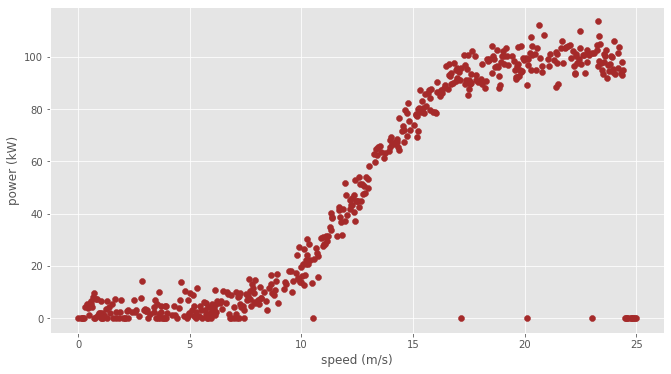

In [5]:
# Plot data on a scatter plot
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.scatter(pp['speed'], pp['power'], color='brown', marker='o')

#### Wind Turbine Power Curve
This plot produces a visualisation of the typical wind turbine power curve. The *cut-in* wind speed is at ~7m/s, below which the turbine is producing hardly any power. Between wind speeds of ~7 and ~17m/s the power ramps up to what is known as the *rated power capacity*. From approximate speeds of ~17m/s the power generated remains constant, right up to ~25m/s, or the *cut-out* wind speed. While there is much potential power in the wind speed above the cut-out speed, the cost of making the turbine capable of producing power under these conditions outweights the benefits of more power being generated [7]. <br>

#### Outliers
What is also notable from the plot is the presence of seeming outliers in the data. There are a number of observations where no power (0kW) is being generated despite sufficiently high wind speeds. This is something which will be examined in greater detail below.

#### What Predictive Model?
Through visualisation we can get a preliminary indication of what model might best be suited when predicting power output from wind speed. Initial inclinations would suggest that this is a *regression* problem. Given that there are only two variables in the data set, simple linear regression may be an appropriate model although fitting a straight line to the data may not yield the most accurate predictions. It might be more suitable to fit a curve. The variables are clearly *positively* correlated between the *cut-in* speed and the *rated power capacity*. 

##### end section 1

<br>



## 2. Function Approximation: Classification vs Regression

***

*Function approximation* is the term used to describe the problem of approximating a mapping function from input variables to output variables. Generally speaking, function approximation problems can be divided into *classification* and *regression* tasks [8]. Deciding between which of these is most appropriate for the current project is the next step.

#### Classification vs Regression
"Classification predictive modeling is the task of approximating a mapping function (f) from input variables (X) to *discrete* output variables (y)" [9], while the output variables for regression models are *continuous* numeric variables. The aim of the current project is to predict power output from wind speed. As noted above, this is a continuous numeric variable which tells us that regression is an appropriate model/function for this task.

#### Regression
Regression is a statistical method which describes the relationship between a dependent variable and one or more independent variables [10]. Additionally, it is associated with fitting a line (or curve) to the data by plotting the line over the data points to get the best fit [11]. Taking a look data as plotted on a scatter plot, it is clear that we could fit a line (or curve) in order to accurately predict the dependent variable.



##### end section 2

<br>



## 3. Regression with `scikit-learn`

***

`scikit-learn` is a machine learning library for the python programming language. It provides a range of machine learning algorithms and is used widely for the purposes of predictive modelling [12]. In the current project, `scikit-learn`'s `LinearRegression` model will be applied to the *powerproduction* data set. Additionally, the package provides a number of tools which will be used to prepare the data and evaluate the models created below.

### 3.1 Data preparation

***

Before building the first model, it is necessary to prepare the data to maximise the ultimate accuracy of the predictions. Firstly, I use a function to detect any outliers in order to improve the performance of the models. Second, I split the data set into subsets using the *train-test split* procedure.


#### 3.1.1 Outliers

When training a predictive model, it is important to remove any outliers so that the data we train the model on most accurately represents the situation at hand. The removal of outliers must be handled sensitively and cautiously so as not to misrepresent the data, and because every data set is different, there is often a lack of clearly defined rules around how to deal with them [13].

Prior to removing any identified outliers, let us first see how a simple linear regression model performs with the orignial data set. The data is split into training and testing data. This procedure is explored and explained in greater detail below:

In [6]:
# Using original (pp) data set to train model 
speed_df_pp = pp.drop('power',axis='columns')
power_df_pp = pp.drop('speed',axis='columns')

# Train test split
A_Train_pp, A_Test_pp, B_Train_pp, B_Test_pp = train_test_split(speed_df_pp, power_df_pp, test_size = 0.5, random_state=1)

# Generate instance of the LinearRegression class to create model
reg_pp = LinearRegression()

# Call the fit method to train model
reg_pp.fit(A_Train_pp, B_Train_pp)

# Calculate R-squared value for evaluation
score_pp = reg_pp.score(A_Test_pp, B_Test_pp)

# Print score
print(score_pp)

0.7196585822445968


Training the model using the full data set yields a score of **~0.72**. This represents the R-Squared value (or coefficient of determination [23]). The R-squared value is a 'goodness-of-fit' measure which can give us an indication as to the accuracy of our regression model. The best possible score is 1.0, while a score of 0 or a negative value generally represents a worse-fitting line. The R-squared value "indicates the percentage of the variance in the dependent variable that the independent variables explain collectively." [24] It is worth noting that a high R-squared does not necessarily always indicate the best fit [25].

<br>

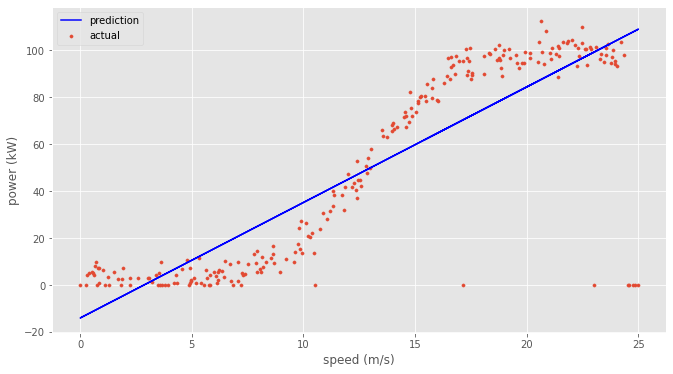

In [7]:
# Use model to make predictions
pp_predict = reg_pp.predict(A_Test_pp)

# Plot fitted line against data for visualisation
plt.scatter(A_Test_pp, B_Test_pp, label='actual', s=10)
plt.plot(A_Test_pp, pp_predict, label='prediction', color='b')

plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

#### 3.1.2 Outlier detection and removal

As we saw above, visualisation can give us a strong indication that some of the observations may need to be removed. However, statistical methods can also be used to detect extreme or unlikely values in a data set. 

##### Mahalonibis Distance

In researching outlier detection, much of the online resources appear to deal with *univariate* outliers [14], [15]. Additionally, detection tools available as part of the `scikit-learn` library e.g. `LocalOutlierFactor`, (which uses the nearest neighbours algorithm to detect outliers in a sample) were not suited to the current project. For *multivariate* outliers, a common statistical method of dection is the *Mahalonibis Distance* measure, which is "... widely used distance metric for the detection of multivariate outliers..." [16]. Indeed it has been applied to wind turbine curve modeling by a number of studies (e.g. Pei and Li, 2019) [17]. 

The code for the function below was found on an informative blog post [18] and applies Mahalonibis Distance to the data set to detect outliers. This function returns a list of index values for the rows containing outliers as detected by the method. I locate these rows using the `pandas.loc` method and remove them from the data set:

In [8]:
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet

# Set variable df to equal pp data set
df = pp

#Robust Mahalonibis Distance
def robust_mahalanobis_method(df):
    #Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ #robust covariance metric
    robust_mean = cov.location_  #robust mean
    inv_covmat = sp.linalg.inv(mcd) #inverse covariance metric
    
    #Robust M-Distance
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))#degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

outliers_mahal_rob, md_rb = robust_mahalanobis_method(df=df)

In [9]:
# Find rows containing outlier indices
pp_outliers = pp.loc[ outliers_mahal_rob , : ]

# Output dataframe of outliers
pp_outliers

,speed,power
340,17.167,0.0
404,20.095,0.0
456,22.998,0.0
490,24.499,0.0
491,24.525,0.0
492,24.575,0.0
493,24.650,0.0
494,24.750,0.0
495,24.775,0.0
496,24.850,0.0


Above is the data frame containing the outlier observations. All the outliers detected have a power value of 0kW. This is what was observed in the scatterplot. Below, I remove them from the data set, creating an updated data set `pp_clean` in the process:

In [10]:
# Remove outliers from data set
pp_clean = pp.drop(outliers_mahal_rob)

In [11]:
# Output statistical summary of updated data frame
pp_clean.describe()

,speed,power
count,487.000000,487.000000
mean,12.294641,49.296287
std,7.077215,41.409933
min,0.000000,0.000000
25%,6.143500,5.769000
50%,12.337000,44.745000
75%,18.380500,93.733500
max,24.399000,113.556000


Text(0, 0.5, 'power (kW)')

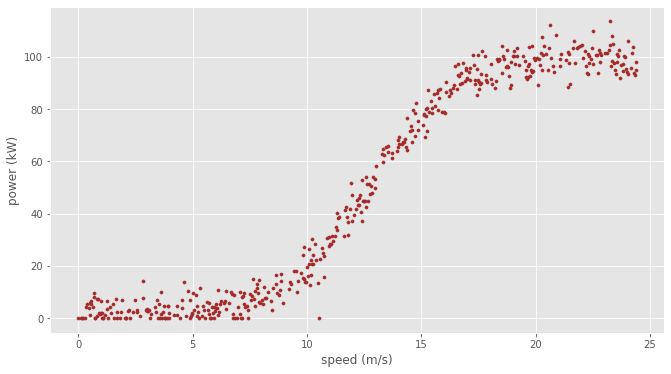

In [12]:
plt.scatter(pp_clean['speed'], pp_clean['power'], color='brown', marker='o', s=10)
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')

The Mahalonibis Distance function detected all but one outlier. I will remove this too for improved performance. Firstly, we view the last 5 observations with power = 0kW:


In [13]:
pp_zero = pp_clean.loc[pp_clean['power'] == 0]
pp_zero.tail()

,speed,power
135,6.857,0.0
136,6.957,0.0
140,7.107,0.0
149,7.432,0.0
208,10.511,0.0


We can see that the outlier is at index 208. This can be removed with the following code:

In [14]:
pp_updated = pp_clean.drop([208])

Now we can train the model with the updated data set:

In [15]:
# Using original (pp) data set to train model 
speed_df_pp_clean = pp_updated.drop('power',axis='columns')
power_df_pp_clean = pp_updated.drop('speed',axis='columns')

# Train test split
x_train, x_test, y_train, y_test = train_test_split(speed_df_pp_clean, power_df_pp_clean, test_size = 0.5, random_state=1)

# Create model
reg_pp_clean = LinearRegression()

# Fit model
reg_pp_clean.fit(x_train, y_train)

# Calculate R-squared value
score_pp_clean = reg_pp_clean.score(x_test, y_test)

# Print score
print(score_pp_clean)

0.9008406364589567


Once the outliers are removed, the model performs better. It yields a score of **~0.90**. 

<br>

We can plot both models side by side for visual comparison:

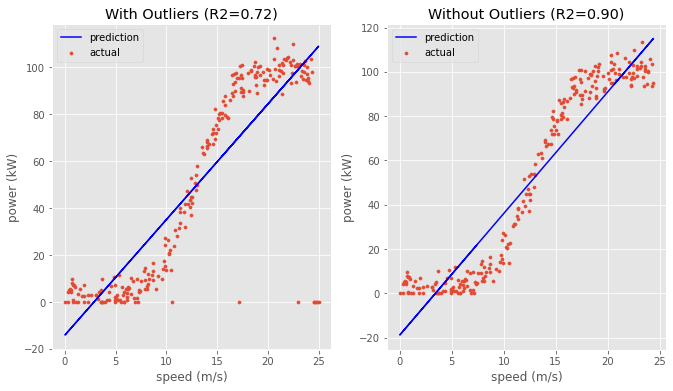

In [16]:
# First subplot
plt.subplot(1, 2, 1)
plt.scatter(A_Test_pp, B_Test_pp, label='actual', s=10)
plt.plot(A_Test_pp, pp_predict, label='prediction', color='b')

plt.title('With Outliers (R2=0.72)')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

# Second subplot
plt.subplot(1, 2, 2)

# Call predict method on test data and plot resulting line
pp_updated_predict = reg_pp_clean.predict(x_test)

plt.scatter(x_test, y_test, label='actual', s=10)
plt.plot(x_test, pp_updated_predict, label='prediction', color='b')

plt.title('Without Outliers (R2=0.90)')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

When viewed side by side, we see that once the outliers are removed the line is a slightly better fit, although it is clear that a straight line does not manage to capture the data accurately in either model.

<br>

#### 3.1.3 Train-test split

This section provides a brief explanation of the *train-test split* procedure as performed in the previous section.

In machine learning, *evaluation* and *validation* are key aspects in measuring how well a model is performing [19]. To ensure that the potential for bias is minimized when evaluating model performance, it is common practice to apply the *train-test split* procedure. This involves training a model by splitting the data into subsets. The *train* subset is used to train the model while the *test* subset is held back in order to test the model's accuracy. Given that we already know the output values for the test subset, we can make informed comparisons between the predicted observed values. (It is worth pointing out that it may not always be appropriate as a technique to increase accuracy of prediction e.g. if the data set is too small [20].) 


<br>

First, the `pp_updated` data set is split by column into two separate subsets, one containing each variable. :

In [17]:
# Create a new dataset containing only values from the speed column
speed_df = pp_updated.drop('power',axis='columns')

#  Print first 10 rows
speed_df.head(10)

,speed
0,0.000
1,0.125
2,0.150
3,0.225
4,0.275
5,0.325
6,0.400
7,0.450
8,0.501
9,0.526


In [18]:
# Create a new dataset containing only values from the power column
power_df = pp_updated.drop('speed',axis='columns')

# Print first 10 rows
power_df.head(10)

,power
0,0.000
1,0.000
2,0.000
3,0.000
4,0.000
5,4.331
6,5.186
7,3.826
8,1.048
9,5.553


<br>

Next, I pass the speed_df and power_df dataframe subsets to `scikit-learn`'s `train_test_split` method and set the parameter *test_size* to 0.5. The test size indicates the size of the train and test sets. Common split percentages include

* Train: 80%, Test: 20%
* Train: 67%, Test: 33%
* Train: 50%, Test: 50% [21]

The values for the train and test subsets are randomly selected, so I set *random_state* to 1. This reproduces the same division of the data each time the program is run. Setting the seed also allows for more representative model comparison as well as parameter comparison when assessing the performance of different models and functions.

**Note: The code below is an exact copy of the procedure as performed above. This is just for demonstration purposes**

In [19]:
# Call train_test_split method on dataframes
x_train, x_test, y_train, y_test = train_test_split(speed_df, power_df, test_size = 0.5, random_state=1)


<br>

### 3.2 Simple linear regression

***

In demonstrating the importance of outlier removal above, I used simple linear regression models. This section provides a brief explanation of simple linear regression before exploring polynomial regression to create a predictive model.

Simple linear regression is "... the simplest case of linear regression with a single independent variable" [22]. Its equation is often expressed as <br> $$ y = \Theta_0 + \Theta_1x $$ <br> It can be applied when the data set contains only two variables - a dependent and independent variable. This is a condition which is filled by the 'powerproduction' data set. 

Once the outliers were removed, the model as trained on the training data produced a score of ~0.90. For certain predictive models, an R-squared value of ~0.90 might be considered satisfactory. However for the current project, it makes sense to attempt to fit a curve to the data to maximise accuracy of predicted output. The following section applies polynomial regression to the data.


<br>

### 3.3 Polynomial regression

***

Visualising the plots above, we can see that a straight line does not follow the curve of the data. This is an example of *under-fitting* [26]. In order to overcome this problem, the complexity of the model needs to be increased. With polynomial regression, we can generate a curve that better captures the data. It involves generating a higher order equation by adding powers to convert features into their higher order terms [27]. The equation for polynomial regression is commonly expressed as: $$ y = \Theta_0 + \Theta_1x + \Theta_2x^2 + \Theta_3x^3 + ... + \Theta_nx^n $$ <br>

`scikit-learn` provides the `PolynomialFeatures` class which enables us to transform features to their higher order terms by setting the degree parameter to the desired power. Then, this model can be trained using the `LinearRegression` class just as above. The code for this is based on an informative towardsdatascience.com blog post [28].

First, the training data is converted to numpy arrays. This makes it easier to sort and plot below. Then, an instance of the `PolynomialFeatures` class is created, generating polynomial degrees to the 9th degree. This is the degree value that yields the highest R-Squared score. The `fit_transform` method applies polynomial transformation of degree 9. The transformed feature (wind speed) is then fitted to the model and predictions are made based on the test data. 

In [20]:
# Convert train and test subsets to numpy arrays
poly_speed_train = x_train.to_numpy().reshape(-1, 1)
poly_power_train = y_train.to_numpy().reshape(-1, 1)
poly_speed_test  = x_test.to_numpy().reshape(-1, 1)
poly_power_test = y_test.to_numpy().reshape(-1, 1)

# Create PolynomialFeatures class instance with degree=9
poly_features = PolynomialFeatures(degree=9)

# Apply polynomial transformation of degree 9
train_speed = poly_features.fit_transform(poly_speed_train)

# Create instance of LinearRegression class
poly_model = LinearRegression()

# Train the model with training data
poly_model.fit(train_speed, poly_power_train)

# Use the model to predict power output of test data
y_test_predict = poly_model.predict(poly_features.fit_transform(poly_speed_test))

<br>

Using `sciki-learn`'s evaluation metrics, we can calculate the R-squared value as well as the *mean-squared-error* (mse), which is the most commonly used regression loss function [29]:

In [22]:
# Calculate mean squared error 
mse = mean_squared_error(poly_power_test, y_test_predict)

# Calculate coeeficient of determination
r2 = r2_score(poly_power_test, y_test_predict)

# Output reults to the screen
mse, r2

(18.29934798625694, 0.9895079443988561)

With an R-Squared value of **~0.99** we can see that polynomial regression performs significantly better than the simple linear regression models above. The mse is **~18.29**. This will be compared with additional models below.

<br>

When plotted on a graph, it is clear that the curve captures the data much more closely:

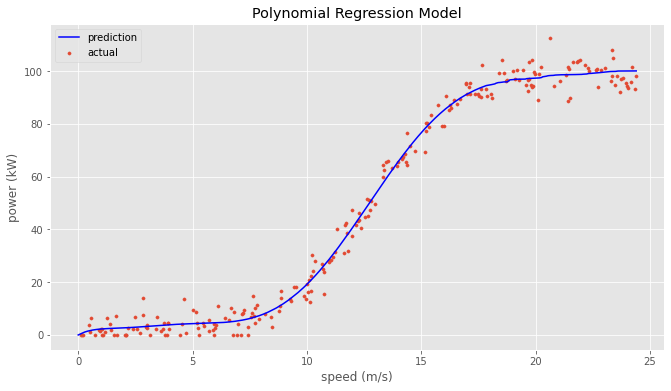

In [23]:
# Plot on scatterplot
plt.scatter(poly_speed_train, poly_power_train, label='actual', s=10)

sorted_poly_speed_test = np.sort(poly_speed_test, 0)
sorted_y_test_predict = np.sort(y_test_predict, 0)


# # Plot line based on model predictions
# plt.plot(sorted_poly_x, sorted_y_test_predict, label='prediction', color='b')
plt.plot(sorted_poly_speed_test, sorted_y_test_predict, label='prediction', color='b')

# Labels
plt.title('Polynomial Regression Model')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

In [ ]:
llop

## Neural network - Regression

***

Neural networks is one of the most commonly used algorithms in machine learning and it covers a broad range of concepts and techniques [30]. Below, I build a neural network which implements regression to predict wind turbine power output from wind speed input. Depending on the nature of the problem to be solved, neural networks can range from simple, with fewer hidden layers (shallower) and fewer neurons in each layer (narrower), to more complex structures (deeper and wider) [31]. 

When applying a neural network model to a problem, there are a number of such parameters which can be tuned in order to minimize the loss function:

* **Number of hidden layers**: Adding more hidden layers can improve the performance of a neural network
* **Number of neurons**: Increasing the number of neurons in a given layer can also minimize the loss function
* **Number of epochs**: When training a model with input data, the algorithm iterates through epochs (cycles). Depending on the data set, a model may need to run through few or many epochs to minimize the loss function sufficiently [32].
* **Batch size**: This refers to the number of training samples the applied to the algorithm before the model's internal parameters are updated [33]
* **Weight parameter**: The neurons in each layer are connected to each previous and following layer, with each connection assigned a weight. For the neural networks created using Keras, this parameter can be set manually or it can be handled by the internal working of the algorithm via the `kernal_initializer` parameter. In the first step of a neural network, the input value is multiplied by its corresponding weight and this is repeated for each input value and added together (dot product between inputs and weights) [34]
* **Bias**: The bias is added to the dot product between inputs and weights. It "... is necessary to make a robust neural network" [35]. Like the weight parameter, the bias can be assigned manually or handled via the `bias_initializer` parameter in each layer. It can ensure, for example, that the dot product will never return a value of zero, which would happen if the input values were zero in a given data set. Adding the bias term is a convention when building neural networks and is often set to 1 as default e.g. in the case described. This calculation can be represented mathematically as: 
<br>

$$f \left( b + \sum_{i=1}^{n}x_iw_i \right)$$ 

<br>
* **Activation function**: The value from this calculation is then passed through an activation function. 

In [ ]:
#pp = pp[pp.power != 0]
#pp.describe()

In [ ]:
# Create neural network with one neuron
def create_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
    
    return model

In [ ]:
model = create_model()

In [ ]:


# msk = np.random.rand(len(pp_clean2)) < 0.5
# train = pp_clean2[msk]

# test = pp_clean2[~msk]

In [ ]:
# model.fit(train['speed'], train['power'], epochs=500, batch_size=10)

In [ ]:
# shapes = model.predict(test['speed'])

In [ ]:
# shapes.shape

In [ ]:
# plt.scatter(test['speed'], test['power'], label='actual', s=10)
# plt.plot(test['speed'], model.predict(test['speed']), label='prediction')
# plt.legend()

In [ ]:
model.fit(x_train, y_train, epochs=500, batch_size=10)

In [ ]:
nn_predict = model.predict(x_test)

nn_predict.shape

In [ ]:
arr_sort = np.sort(nn_predict, axis=0)

In [ ]:
nn_predict = np.sort(nn_predict, axis=0)
A_Test_sort = np.sort(x_test, axis=0)

plt.scatter(x_train, y_train, label='actual', s=10)

# sort_axis_nn = operator.itemgetter(0)
# sorted_zip_nn = sorted(zip(A_Test, nn_predict), key=sort_axis)
# sorted_poly_x_nn, sorted_y_test_predict_nn = zip(*sorted_zip)

plt.plot(A_Test_sort, nn_predict, label='prediction', color='b')
plt.legend()

In [ ]:
model.summary()

In [ ]:
# model.save('my_model.h5')

In [ ]:
model.predict([14])

In [26]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

dataset = pp_updated.values
# split into input (X) and output (Y) variables
X = dataset[:,0:1]
Y = dataset[:,1]

def some_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(10, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.01), loss='mean_squared_error')
    
    return model




# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
estimators.append(('mlp', KerasRegressor(build_fn=some_model, epochs=300, batch_size=10)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)

Epoch 1/300
44/44 [==============================] - 1s 3ms/step - loss: 4960.7851
Epoch 2/300
44/44 [==============================] - 0s 3ms/step - loss: 4043.8838
Epoch 3/300
44/44 [==============================] - 0s 2ms/step - loss: 3899.5912
Epoch 4/300
44/44 [==============================] - 0s 3ms/step - loss: 3399.4959
Epoch 5/300
44/44 [==============================] - 0s 3ms/step - loss: 2982.3365
Epoch 6/300
44/44 [==============================] - 0s 3ms/step - loss: 2350.8164
Epoch 7/300
44/44 [==============================] - 0s 2ms/step - loss: 2188.9339
Epoch 8/300
44/44 [==============================] - 0s 3ms/step - loss: 2039.8738
Epoch 9/300
44/44 [==============================] - 0s 3ms/step - loss: 1641.4176
Epoch 10/300
44/44 [==============================] - 0s 3ms/step - loss: 1484.2717
Epoch 11/300
44/44 [==============================] - 0s 3ms/step - loss: 1256.1332
Epoch 12/300
44/44 [==============================] - 0s 3ms/step - loss: 1013.8721
E

44/44 [==============================] - 0s 2ms/step - loss: 17.2504
Epoch 101/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9271
Epoch 102/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1755
Epoch 103/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8091
Epoch 104/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5820
Epoch 105/300
44/44 [==============================] - 0s 2ms/step - loss: 19.9732
Epoch 106/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8838
Epoch 107/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8015
Epoch 108/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4468
Epoch 109/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8661
Epoch 110/300
44/44 [==============================] - 0s 3ms/step - loss: 19.9472
Epoch 111/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9282
Epoch 112/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.4521
Epoch 199/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8115
Epoch 200/300
44/44 [==============================] - 0s 3ms/step - loss: 18.1964
Epoch 201/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4731
Epoch 202/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4278
Epoch 203/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3153
Epoch 204/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5548
Epoch 205/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4307
Epoch 206/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9703
Epoch 207/300
44/44 [==============================] - 0s 2ms/step - loss: 20.4165
Epoch 208/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3595
Epoch 209/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5987
Epoch 210/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.9959
Epoch 297/300
44/44 [==============================] - 0s 3ms/step - loss: 16.1763
Epoch 298/300
44/44 [==============================] - 0s 3ms/step - loss: 15.7753
Epoch 299/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9286
Epoch 300/300
5/5 [==============================] - 0s 3ms/step - loss: 8.0521
Epoch 1/300
44/44 [==============================] - 1s 2ms/step - loss: 4358.3441
Epoch 2/300
44/44 [==============================] - 0s 2ms/step - loss: 3857.9819
Epoch 3/300
44/44 [==============================] - 0s 2ms/step - loss: 3350.2350
Epoch 4/300
44/44 [==============================] - 0s 2ms/step - loss: 3046.2304
Epoch 5/300
44/44 [==============================] - 0s 2ms/step - loss: 2863.6455
Epoch 6/300
44/44 [==============================] - 0s 2ms/step - loss: 2264.0303
Epoch 7/300
44/44 [==============================] - 0s 2ms/step - loss: 1904.6828
Epoch 8/300
44/44 [==

44/44 [==============================] - 0s 2ms/step - loss: 17.0675
Epoch 95/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1980
Epoch 96/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2630
Epoch 97/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1998
Epoch 98/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5257
Epoch 99/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5666
Epoch 100/300
44/44 [==============================] - 0s 2ms/step - loss: 19.1624
Epoch 101/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8725
Epoch 102/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2186
Epoch 103/300
44/44 [==============================] - 0s 2ms/step - loss: 19.0408
Epoch 104/300
44/44 [==============================] - 0s 2ms/step - loss: 19.0873
Epoch 105/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9427
Epoch 106/300
44/44 [==

44/44 [==============================] - 0s 2ms/step - loss: 17.4982
Epoch 193/300
44/44 [==============================] - 0s 2ms/step - loss: 19.1672
Epoch 194/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9938
Epoch 195/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5154
Epoch 196/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6822
Epoch 197/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9128
Epoch 198/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8588
Epoch 199/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7067
Epoch 200/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8895
Epoch 201/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8574
Epoch 202/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6065
Epoch 203/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1250
Epoch 204/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 15.4449
Epoch 291/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2755
Epoch 292/300
44/44 [==============================] - 0s 3ms/step - loss: 17.7095
Epoch 293/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0960
Epoch 294/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7097
Epoch 295/300
44/44 [==============================] - 0s 3ms/step - loss: 18.0986
Epoch 296/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1838
Epoch 297/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3651
Epoch 298/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9998
Epoch 299/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7796
Epoch 300/300
5/5 [==============================] - 0s 4ms/step - loss: 12.8443
Epoch 1/300
44/44 [==============================] - 1s 3ms/step - loss: 4297.1594
Epoch 2/300
44/44 [=

44/44 [==============================] - 0s 3ms/step - loss: 18.9791
Epoch 89/300
44/44 [==============================] - 0s 3ms/step - loss: 20.3327
Epoch 90/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1955
Epoch 91/300
44/44 [==============================] - 0s 2ms/step - loss: 20.2900
Epoch 92/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5787
Epoch 93/300
44/44 [==============================] - 0s 3ms/step - loss: 17.2302
Epoch 94/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5912
Epoch 95/300
44/44 [==============================] - 0s 2ms/step - loss: 20.1536
Epoch 96/300
44/44 [==============================] - 0s 2ms/step - loss: 19.9314
Epoch 97/300
44/44 [==============================] - 0s 3ms/step - loss: 17.1806
Epoch 98/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1911
Epoch 99/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6562
Epoch 100/300
44/44 [========

44/44 [==============================] - 0s 3ms/step - loss: 18.2642
Epoch 187/300
44/44 [==============================] - 0s 3ms/step - loss: 15.8505
Epoch 188/300
44/44 [==============================] - 0s 3ms/step - loss: 17.1527
Epoch 189/300
44/44 [==============================] - 0s 3ms/step - loss: 17.8765
Epoch 190/300
44/44 [==============================] - 0s 3ms/step - loss: 14.4456
Epoch 191/300
44/44 [==============================] - 0s 3ms/step - loss: 16.0030
Epoch 192/300
44/44 [==============================] - 0s 3ms/step - loss: 20.0149
Epoch 193/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7244
Epoch 194/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3743
Epoch 195/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5706
Epoch 196/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8745
Epoch 197/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2790
Epoch 198/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 18.1462
Epoch 285/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5745
Epoch 286/300
44/44 [==============================] - 0s 3ms/step - loss: 15.7958
Epoch 287/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1448
Epoch 288/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6429
Epoch 289/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3195
Epoch 290/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0751
Epoch 291/300
44/44 [==============================] - 0s 3ms/step - loss: 16.7445
Epoch 292/300
44/44 [==============================] - 0s 3ms/step - loss: 17.1109
Epoch 293/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0636
Epoch 294/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4795
Epoch 295/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5785
Epoch 296/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.0357
Epoch 83/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6015
Epoch 84/300
44/44 [==============================] - 0s 3ms/step - loss: 17.1879
Epoch 85/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3103
Epoch 86/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2094
Epoch 87/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5124
Epoch 88/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6227
Epoch 89/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4931
Epoch 90/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2479
Epoch 91/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4502
Epoch 92/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3349
Epoch 93/300
44/44 [==============================] - 0s 2ms/step - loss: 19.1371
Epoch 94/300
44/44 [=========

44/44 [==============================] - 0s 3ms/step - loss: 17.7934
Epoch 181/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7108
Epoch 182/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0370
Epoch 183/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8911
Epoch 184/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9437
Epoch 185/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5523
Epoch 186/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2255
Epoch 187/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9021
Epoch 188/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7768
Epoch 189/300
44/44 [==============================] - 0s 3ms/step - loss: 17.4809
Epoch 190/300
44/44 [==============================] - 0s 3ms/step - loss: 17.5650
Epoch 191/300
44/44 [==============================] - 0s 3ms/step - loss: 18.2415
Epoch 192/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.3684
Epoch 279/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8020
Epoch 280/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7320
Epoch 281/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4916
Epoch 282/300
44/44 [==============================] - 0s 2ms/step - loss: 14.5986
Epoch 283/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0491
Epoch 284/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5745
Epoch 285/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3257
Epoch 286/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2044
Epoch 287/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9408
Epoch 288/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3464
Epoch 289/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5191
Epoch 290/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.8601
Epoch 77/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6617
Epoch 78/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2374
Epoch 79/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7449
Epoch 80/300
44/44 [==============================] - 0s 3ms/step - loss: 17.8231
Epoch 81/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3665
Epoch 82/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3734
Epoch 83/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2856
Epoch 84/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9273
Epoch 85/300
44/44 [==============================] - 0s 2ms/step - loss: 15.6317
Epoch 86/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2744
Epoch 87/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6358
Epoch 88/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 15.1363
Epoch 176/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7428
Epoch 177/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2359
Epoch 178/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0059
Epoch 179/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5163
Epoch 180/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0668
Epoch 181/300
44/44 [==============================] - 0s 3ms/step - loss: 15.8199
Epoch 182/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6566
Epoch 183/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8952
Epoch 184/300
44/44 [==============================] - 0s 2ms/step - loss: 13.8355
Epoch 185/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9076
Epoch 186/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5660
Epoch 187/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 15.7137
Epoch 274/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9939
Epoch 275/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5774
Epoch 276/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5819
Epoch 277/300
44/44 [==============================] - 0s 2ms/step - loss: 14.0607
Epoch 278/300
44/44 [==============================] - 0s 3ms/step - loss: 14.9477
Epoch 279/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0952
Epoch 280/300
44/44 [==============================] - 0s 2ms/step - loss: 14.9266
Epoch 281/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5301
Epoch 282/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9854
Epoch 283/300
44/44 [==============================] - 0s 2ms/step - loss: 14.1195
Epoch 284/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6851
Epoch 285/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 15.8519
Epoch 72/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3925
Epoch 73/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9348
Epoch 74/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8264
Epoch 75/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9850
Epoch 76/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9507
Epoch 77/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3046
Epoch 78/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6311
Epoch 79/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1678
Epoch 80/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1247
Epoch 81/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5351
Epoch 82/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8374
Epoch 83/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 15.4718
Epoch 171/300
44/44 [==============================] - 0s 3ms/step - loss: 15.7130
Epoch 172/300
44/44 [==============================] - 0s 2ms/step - loss: 14.6629
Epoch 173/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3053
Epoch 174/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4458
Epoch 175/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8302
Epoch 176/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4691
Epoch 177/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8526
Epoch 178/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2809
Epoch 179/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2081
Epoch 180/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9626
Epoch 181/300
44/44 [==============================] - 0s 3ms/step - loss: 19.2547
Epoch 182/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.4428
Epoch 269/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0211
Epoch 270/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7951
Epoch 271/300
44/44 [==============================] - 0s 2ms/step - loss: 14.3380
Epoch 272/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0617
Epoch 273/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1252
Epoch 274/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7658
Epoch 275/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8429
Epoch 276/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9475
Epoch 277/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0478
Epoch 278/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2295
Epoch 279/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7619
Epoch 280/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 16.3669
Epoch 67/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7019
Epoch 68/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7015
Epoch 69/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9110
Epoch 70/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5187
Epoch 71/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3351
Epoch 72/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4296
Epoch 73/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3386
Epoch 74/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7473
Epoch 75/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6165
Epoch 76/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8307
Epoch 77/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3480
Epoch 78/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 16.0130
Epoch 166/300
44/44 [==============================] - 0s 2ms/step - loss: 15.6460
Epoch 167/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6061
Epoch 168/300
44/44 [==============================] - 0s 3ms/step - loss: 16.0994
Epoch 169/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7464
Epoch 170/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1752
Epoch 171/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5078
Epoch 172/300
44/44 [==============================] - 0s 2ms/step - loss: 14.9716
Epoch 173/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2888
Epoch 174/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7102
Epoch 175/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7407
Epoch 176/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0431
Epoch 177/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.0428
Epoch 264/300
44/44 [==============================] - 0s 2ms/step - loss: 15.2809
Epoch 265/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5782
Epoch 266/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4637
Epoch 267/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8599
Epoch 268/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4886
Epoch 269/300
44/44 [==============================] - 0s 2ms/step - loss: 15.2270
Epoch 270/300
44/44 [==============================] - 0s 2ms/step - loss: 15.2268
Epoch 271/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0215
Epoch 272/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6757
Epoch 273/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8601
Epoch 274/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4142
Epoch 275/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 20.5936
Epoch 62/300
44/44 [==============================] - 0s 2ms/step - loss: 20.2559
Epoch 63/300
44/44 [==============================] - 0s 2ms/step - loss: 19.6364
Epoch 64/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7915
Epoch 65/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1981
Epoch 66/300
44/44 [==============================] - 0s 3ms/step - loss: 17.3591
Epoch 67/300
44/44 [==============================] - 0s 3ms/step - loss: 15.5133
Epoch 68/300
44/44 [==============================] - 0s 3ms/step - loss: 18.8790
Epoch 69/300
44/44 [==============================] - 0s 3ms/step - loss: 16.4334
Epoch 70/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2232
Epoch 71/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3703
Epoch 72/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9162
Epoch 73/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 14.7160
Epoch 161/300
44/44 [==============================] - 0s 3ms/step - loss: 14.1783
Epoch 162/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5751
Epoch 163/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9687
Epoch 164/300
44/44 [==============================] - 0s 3ms/step - loss: 14.6610
Epoch 165/300
44/44 [==============================] - 0s 3ms/step - loss: 15.3331
Epoch 166/300
44/44 [==============================] - 0s 3ms/step - loss: 13.8364
Epoch 167/300
44/44 [==============================] - 0s 3ms/step - loss: 14.8320
Epoch 168/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0723
Epoch 169/300
44/44 [==============================] - 0s 3ms/step - loss: 16.5558
Epoch 170/300
44/44 [==============================] - 0s 3ms/step - loss: 14.9071
Epoch 171/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5030
Epoch 172/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 13.2850
Epoch 259/300
44/44 [==============================] - 0s 3ms/step - loss: 16.2229
Epoch 260/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8813
Epoch 261/300
44/44 [==============================] - 0s 3ms/step - loss: 14.9679
Epoch 262/300
44/44 [==============================] - 0s 3ms/step - loss: 15.9106
Epoch 263/300
44/44 [==============================] - 0s 3ms/step - loss: 16.1508: 0s - loss: 16.18
Epoch 264/300
44/44 [==============================] - 0s 3ms/step - loss: 16.5804
Epoch 265/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0038
Epoch 266/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5992
Epoch 267/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0804
Epoch 268/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3490
Epoch 269/300
44/44 [==============================] - 0s 2ms/step - loss: 14.8126


44/44 [==============================] - 0s 2ms/step - loss: 19.1790
Epoch 57/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6553
Epoch 58/300
44/44 [==============================] - 0s 2ms/step - loss: 19.9251
Epoch 59/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2291
Epoch 60/300
44/44 [==============================] - 0s 3ms/step - loss: 17.7664
Epoch 61/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6536
Epoch 62/300
44/44 [==============================] - 0s 3ms/step - loss: 16.9847
Epoch 63/300
44/44 [==============================] - 0s 3ms/step - loss: 16.8073
Epoch 64/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4104
Epoch 65/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9665
Epoch 66/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7131
Epoch 67/300
44/44 [==============================] - 0s 3ms/step - loss: 18.2475
Epoch 68/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 15.5237
Epoch 156/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9906
Epoch 157/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4499
Epoch 158/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3057
Epoch 159/300
44/44 [==============================] - 0s 2ms/step - loss: 14.6282
Epoch 160/300
44/44 [==============================] - 0s 2ms/step - loss: 15.2552
Epoch 161/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5883
Epoch 162/300
44/44 [==============================] - 0s 2ms/step - loss: 14.9936
Epoch 163/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6128
Epoch 164/300
44/44 [==============================] - 0s 2ms/step - loss: 14.4199
Epoch 165/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4568
Epoch 166/300
44/44 [==============================] - 0s 2ms/step - loss: 14.8906
Epoch 167/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 15.8730
Epoch 254/300
44/44 [==============================] - 0s 2ms/step - loss: 14.1450
Epoch 255/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2815
Epoch 256/300
44/44 [==============================] - 0s 2ms/step - loss: 14.9659
Epoch 257/300
44/44 [==============================] - 0s 3ms/step - loss: 15.5373
Epoch 258/300
44/44 [==============================] - 0s 2ms/step - loss: 13.4706
Epoch 259/300
44/44 [==============================] - ETA: 0s - loss: 14.97 - 0s 2ms/step - loss: 15.2312
Epoch 260/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7376
Epoch 261/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3552
Epoch 262/300
44/44 [==============================] - 0s 2ms/step - loss: 13.8751
Epoch 263/300
44/44 [==============================] - 0s 2ms/step - loss: 14.2395
Epoch 264/300
44/44 [==============================] - 0s 3ms/step - loss: 16

44/44 [==============================] - 0s 2ms/step - loss: 20.1719
Epoch 52/300
44/44 [==============================] - 0s 2ms/step - loss: 25.0042
Epoch 53/300
44/44 [==============================] - 0s 2ms/step - loss: 21.4557
Epoch 54/300
44/44 [==============================] - 0s 2ms/step - loss: 21.6653
Epoch 55/300
44/44 [==============================] - 0s 2ms/step - loss: 22.0619
Epoch 56/300
44/44 [==============================] - 0s 2ms/step - loss: 19.4146
Epoch 57/300
44/44 [==============================] - 0s 2ms/step - loss: 20.1756
Epoch 58/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5405
Epoch 59/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3473
Epoch 60/300
44/44 [==============================] - 0s 2ms/step - loss: 19.0907
Epoch 61/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8892
Epoch 62/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7539
Epoch 63/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 16.9230
Epoch 151/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5564
Epoch 152/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2945
Epoch 153/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9503
Epoch 154/300
44/44 [==============================] - 0s 2ms/step - loss: 14.1227
Epoch 155/300
44/44 [==============================] - 0s 2ms/step - loss: 14.6909
Epoch 156/300
44/44 [==============================] - 0s 2ms/step - loss: 14.6567
Epoch 157/300
44/44 [==============================] - 0s 2ms/step - loss: 13.9529
Epoch 158/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9726
Epoch 159/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0250
Epoch 160/300
44/44 [==============================] - 0s 2ms/step - loss: 15.6488
Epoch 161/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2084
Epoch 162/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 13.9082
Epoch 249/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3552
Epoch 250/300
44/44 [==============================] - 0s 2ms/step - loss: 14.6575
Epoch 251/300
44/44 [==============================] - 0s 2ms/step - loss: 15.1182
Epoch 252/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3765
Epoch 253/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5144
Epoch 254/300
44/44 [==============================] - 0s 2ms/step - loss: 14.0030
Epoch 255/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3862
Epoch 256/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4676
Epoch 257/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1129
Epoch 258/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4467
Epoch 259/300
44/44 [==============================] - 0s 3ms/step - loss: 15.8415
Epoch 260/300
44/4

In [24]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

dataset = pp_updated.values
# split into input (X) and output (Y) variables
X = dataset[:,0:1]
Y = dataset[:,1]
# define base model
def baseline_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
#     model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.01), loss='mean_squared_error')
    
    return model




# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=300, batch_size=10)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)


Epoch 1/300
44/44 [==============================] - 1s 2ms/step - loss: 3851.2706
Epoch 2/300
44/44 [==============================] - 0s 2ms/step - loss: 1897.2460
Epoch 3/300
44/44 [==============================] - 0s 2ms/step - loss: 713.7056
Epoch 4/300
44/44 [==============================] - 0s 3ms/step - loss: 320.3583
Epoch 5/300
44/44 [==============================] - 0s 2ms/step - loss: 152.5381
Epoch 6/300
44/44 [==============================] - 0s 3ms/step - loss: 98.8601
Epoch 7/300
44/44 [==============================] - 0s 2ms/step - loss: 64.5774
Epoch 8/300
44/44 [==============================] - 0s 3ms/step - loss: 56.1992
Epoch 9/300
44/44 [==============================] - 0s 2ms/step - loss: 45.1959
Epoch 10/300
44/44 [==============================] - 0s 3ms/step - loss: 43.8031
Epoch 11/300
44/44 [==============================] - 0s 3ms/step - loss: 42.4647
Epoch 12/300
44/44 [==============================] - 0s 3ms/step - loss: 34.8379
Epoch 13/300
44/44

44/44 [==============================] - 0s 2ms/step - loss: 18.0133
Epoch 101/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0730
Epoch 102/300
44/44 [==============================] - 0s 2ms/step - loss: 19.1968
Epoch 103/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7360
Epoch 104/300
44/44 [==============================] - 0s 2ms/step - loss: 19.0474
Epoch 105/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2396
Epoch 106/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9338
Epoch 107/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9050
Epoch 108/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4490
Epoch 109/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3557
Epoch 110/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8248
Epoch 111/300
44/44 [==============================] - 0s 2ms/step - loss: 20.7138
Epoch 112/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.0822
Epoch 199/300
44/44 [==============================] - 0s 3ms/step - loss: 18.1808
Epoch 200/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6730
Epoch 201/300
44/44 [==============================] - 0s 3ms/step - loss: 16.9741
Epoch 202/300
44/44 [==============================] - 0s 2ms/step - loss: 20.1878
Epoch 203/300
44/44 [==============================] - 0s 2ms/step - loss: 21.2938
Epoch 204/300
44/44 [==============================] - 0s 2ms/step - loss: 20.2943
Epoch 205/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8632
Epoch 206/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4888
Epoch 207/300
44/44 [==============================] - 0s 2ms/step - loss: 19.7850
Epoch 208/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4848
Epoch 209/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7280
Epoch 210/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 20.0445
Epoch 297/300
44/44 [==============================] - 0s 2ms/step - loss: 19.6015
Epoch 298/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1016
Epoch 299/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5131
Epoch 300/300
5/5 [==============================] - 0s 4ms/step - loss: 7.9339
Epoch 1/300
44/44 [==============================] - 1s 2ms/step - loss: 3845.0072
Epoch 2/300
44/44 [==============================] - ETA: 0s - loss: 1894.26 - 0s 2ms/step - loss: 1776.1832
Epoch 3/300
44/44 [==============================] - 0s 2ms/step - loss: 716.4248
Epoch 4/300
44/44 [==============================] - 0s 2ms/step - loss: 362.0614
Epoch 5/300
44/44 [==============================] - 0s 2ms/step - loss: 195.4234
Epoch 6/300
44/44 [==============================] - 0s 3ms/step - loss: 110.5590
Epoch 7/300
44/44 [==============================] - 0s 2ms/step - loss: 78.0267
E

44/44 [==============================] - 0s 2ms/step - loss: 19.5780
Epoch 95/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9666
Epoch 96/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3630
Epoch 97/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1969
Epoch 98/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8113
Epoch 99/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6740
Epoch 100/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4607
Epoch 101/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7979
Epoch 102/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6876
Epoch 103/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2184
Epoch 104/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6994
Epoch 105/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2211
Epoch 106/300
44/44 [==

44/44 [==============================] - 0s 2ms/step - loss: 19.9800
Epoch 193/300
44/44 [==============================] - 0s 3ms/step - loss: 20.1247
Epoch 194/300
44/44 [==============================] - 0s 3ms/step - loss: 17.4900
Epoch 195/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0319
Epoch 196/300
44/44 [==============================] - 0s 2ms/step - loss: 19.4959
Epoch 197/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0483
Epoch 198/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1716
Epoch 199/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9990
Epoch 200/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3938
Epoch 201/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9319
Epoch 202/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1385
Epoch 203/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5131
Epoch 204/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 15.7152
Epoch 291/300
44/44 [==============================] - 0s 3ms/step - loss: 18.1207
Epoch 292/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7053
Epoch 293/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7784
Epoch 294/300
44/44 [==============================] - 0s 3ms/step - loss: 18.9326
Epoch 295/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3941
Epoch 296/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2702
Epoch 297/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7880
Epoch 298/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7887
Epoch 299/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9378
Epoch 300/300
5/5 [==============================] - 0s 4ms/step - loss: 13.1346
Epoch 1/300
44/44 [==============================] - 1s 3ms/step - loss: 3880.0982
Epoch 2/300
44/44 [=

44/44 [==============================] - 0s 2ms/step - loss: 17.8324
Epoch 90/300
44/44 [==============================] - 0s 3ms/step - loss: 16.7049
Epoch 91/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9253
Epoch 92/300
44/44 [==============================] - 0s 2ms/step - loss: 21.8775
Epoch 93/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9865
Epoch 94/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6741
Epoch 95/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9875
Epoch 96/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1696
Epoch 97/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9732
Epoch 98/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8202
Epoch 99/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8615
Epoch 100/300
44/44 [==============================] - 0s 3ms/step - loss: 17.3031
Epoch 101/300
44/44 [=======

44/44 [==============================] - 0s 2ms/step - loss: 17.7175
Epoch 188/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7255
Epoch 189/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8286
Epoch 190/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1887
Epoch 191/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0243
Epoch 192/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8002
Epoch 193/300
44/44 [==============================] - 0s 3ms/step - loss: 17.5504
Epoch 194/300
44/44 [==============================] - 0s 3ms/step - loss: 17.0346
Epoch 195/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4440
Epoch 196/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1099
Epoch 197/300
44/44 [==============================] - 0s 2ms/step - loss: 13.6887
Epoch 198/300
44/44 [==============================] - 0s 3ms/step - loss: 18.4347
Epoch 199/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.0922
Epoch 286/300
44/44 [==============================] - 0s 3ms/step - loss: 18.3780
Epoch 287/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7837
Epoch 288/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9669
Epoch 289/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5382
Epoch 290/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0584
Epoch 291/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3272
Epoch 292/300
44/44 [==============================] - 0s 3ms/step - loss: 18.1004
Epoch 293/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8321
Epoch 294/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0506
Epoch 295/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8831
Epoch 296/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7937
Epoch 297/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.7939
Epoch 85/300
44/44 [==============================] - 0s 2ms/step - loss: 19.4079
Epoch 86/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3229
Epoch 87/300
44/44 [==============================] - 0s 3ms/step - loss: 16.8417
Epoch 88/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3434
Epoch 89/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7851
Epoch 90/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4303
Epoch 91/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6221
Epoch 92/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9353
Epoch 93/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8542
Epoch 94/300
44/44 [==============================] - 0s 2ms/step - loss: 14.6263
Epoch 95/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4414
Epoch 96/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 16.3672
Epoch 184/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1700
Epoch 185/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9251
Epoch 186/300
44/44 [==============================] - 0s 2ms/step - loss: 14.7975
Epoch 187/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4186
Epoch 188/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7784
Epoch 189/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8605
Epoch 190/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8862
Epoch 191/300
44/44 [==============================] - 0s 3ms/step - loss: 17.4313
Epoch 192/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2195
Epoch 193/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1524
Epoch 194/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4052
Epoch 195/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 18.1001
Epoch 282/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1702
Epoch 283/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8844
Epoch 284/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2807
Epoch 285/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4305
Epoch 286/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5132
Epoch 287/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0905
Epoch 288/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6057
Epoch 289/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0052
Epoch 290/300
44/44 [==============================] - 0s 2ms/step - loss: 19.0615
Epoch 291/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3302
Epoch 292/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8441
Epoch 293/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.5934
Epoch 80/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8694
Epoch 81/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4664
Epoch 82/300
44/44 [==============================] - 0s 3ms/step - loss: 15.6950
Epoch 83/300
44/44 [==============================] - 0s 2ms/step - loss: 15.6968
Epoch 84/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3114
Epoch 85/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1747
Epoch 86/300
44/44 [==============================] - 0s 3ms/step - loss: 16.5504
Epoch 87/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6488
Epoch 88/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4859
Epoch 89/300
44/44 [==============================] - 0s 2ms/step - loss: 13.6490
Epoch 90/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1380
Epoch 91/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 15.6483
Epoch 179/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3247
Epoch 180/300
44/44 [==============================] - 0s 3ms/step - loss: 15.4070
Epoch 181/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3700
Epoch 182/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9146
Epoch 183/300
44/44 [==============================] - 0s 2ms/step - loss: 14.6341
Epoch 184/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0994
Epoch 185/300
44/44 [==============================] - 0s 3ms/step - loss: 16.4245
Epoch 186/300
44/44 [==============================] - 0s 2ms/step - loss: 14.6044
Epoch 187/300
44/44 [==============================] - 0s 3ms/step - loss: 15.2828
Epoch 188/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7305
Epoch 189/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3533
Epoch 190/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 15.7994
Epoch 277/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2078
Epoch 278/300
44/44 [==============================] - 0s 2ms/step - loss: 19.8255
Epoch 279/300
44/44 [==============================] - 0s 2ms/step - loss: 14.1546
Epoch 280/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5132
Epoch 281/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8261
Epoch 282/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7398
Epoch 283/300
44/44 [==============================] - 0s 2ms/step - loss: 15.2313
Epoch 284/300
44/44 [==============================] - 0s 2ms/step - loss: 15.2824
Epoch 285/300
44/44 [==============================] - 0s 3ms/step - loss: 19.2294
Epoch 286/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1203
Epoch 287/300
44/44 [==============================] - 0s 2ms/step - loss: 14.5983
Epoch 288/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 16.4367
Epoch 75/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6339
Epoch 76/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8177
Epoch 77/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8199
Epoch 78/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0411
Epoch 79/300
44/44 [==============================] - 0s 3ms/step - loss: 17.3417
Epoch 80/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3285
Epoch 81/300
44/44 [==============================] - 0s 3ms/step - loss: 16.5533
Epoch 82/300
44/44 [==============================] - 0s 3ms/step - loss: 16.5370
Epoch 83/300
44/44 [==============================] - 0s 3ms/step - loss: 16.9017
Epoch 84/300
44/44 [==============================] - 0s 3ms/step - loss: 18.8518
Epoch 85/300
44/44 [==============================] - 0s 3ms/step - loss: 16.4991
Epoch 86/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 16.4822
Epoch 173/300
44/44 [==============================] - 0s 3ms/step - loss: 17.2353
Epoch 174/300
44/44 [==============================] - 0s 2ms/step - loss: 19.9841
Epoch 175/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9562
Epoch 176/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4206
Epoch 177/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3294
Epoch 178/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2098
Epoch 179/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8869
Epoch 180/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3335
Epoch 181/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3624
Epoch 182/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2961
Epoch 183/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0871
Epoch 184/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.9426
Epoch 271/300
44/44 [==============================] - 0s 3ms/step - loss: 17.5247
Epoch 272/300
44/44 [==============================] - 0s 3ms/step - loss: 16.6719
Epoch 273/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2982
Epoch 274/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7623
Epoch 275/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0133
Epoch 276/300
44/44 [==============================] - 0s 2ms/step - loss: 19.1118
Epoch 277/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8967
Epoch 278/300
44/44 [==============================] - 0s 2ms/step - loss: 20.4280
Epoch 279/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5178
Epoch 280/300
44/44 [==============================] - 0s 3ms/step - loss: 15.8563
Epoch 281/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5376
Epoch 282/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 18.6489
Epoch 69/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2344
Epoch 70/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5633
Epoch 71/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0026
Epoch 72/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4157
Epoch 73/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4617
Epoch 74/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0173
Epoch 75/300
44/44 [==============================] - 0s 2ms/step - loss: 19.6109
Epoch 76/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7286
Epoch 77/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1321
Epoch 78/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2935
Epoch 79/300
44/44 [==============================] - 0s 3ms/step - loss: 16.3662
Epoch 80/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 18.8346
Epoch 168/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1087
Epoch 169/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9814
Epoch 170/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1203
Epoch 171/300
44/44 [==============================] - 0s 3ms/step - loss: 16.4348
Epoch 172/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6680
Epoch 173/300
44/44 [==============================] - 0s 3ms/step - loss: 15.5587
Epoch 174/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8738
Epoch 175/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7694
Epoch 176/300
44/44 [==============================] - 0s 3ms/step - loss: 17.1589
Epoch 177/300
44/44 [==============================] - 0s 2ms/step - loss: 15.1670
Epoch 178/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9747
Epoch 179/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.1321
Epoch 266/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3305
Epoch 267/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9282
Epoch 268/300
44/44 [==============================] - 0s 2ms/step - loss: 15.1297
Epoch 269/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9724
Epoch 270/300
44/44 [==============================] - 0s 3ms/step - loss: 16.2603
Epoch 271/300
44/44 [==============================] - 0s 3ms/step - loss: 18.6977
Epoch 272/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3582
Epoch 273/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0441
Epoch 274/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7474
Epoch 275/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5635
Epoch 276/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4395
Epoch 277/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 17.0152
Epoch 64/300
44/44 [==============================] - 0s 3ms/step - loss: 17.5024
Epoch 65/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3501
Epoch 66/300
44/44 [==============================] - 0s 2ms/step - loss: 15.6208
Epoch 67/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5588
Epoch 68/300
44/44 [==============================] - 0s 3ms/step - loss: 13.8943
Epoch 69/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0543
Epoch 70/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1332
Epoch 71/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7042
Epoch 72/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5099
Epoch 73/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9110
Epoch 74/300
44/44 [==============================] - 0s 3ms/step - loss: 17.6584
Epoch 75/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 18.4171
Epoch 163/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6425
Epoch 164/300
44/44 [==============================] - 0s 2ms/step - loss: 14.6956
Epoch 165/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2177
Epoch 166/300
44/44 [==============================] - 0s 2ms/step - loss: 19.1212
Epoch 167/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7283
Epoch 168/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9944
Epoch 169/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3218
Epoch 170/300
44/44 [==============================] - 0s 3ms/step - loss: 15.5156
Epoch 171/300
44/44 [==============================] - 0s 2ms/step - loss: 15.1252
Epoch 172/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5667
Epoch 173/300
44/44 [==============================] - 0s 2ms/step - loss: 14.9196
Epoch 174/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 15.8894
Epoch 261/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5138
Epoch 262/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2588
Epoch 263/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1250
Epoch 264/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9485
Epoch 265/300
44/44 [==============================] - 0s 3ms/step - loss: 17.7585
Epoch 266/300
44/44 [==============================] - 0s 3ms/step - loss: 14.6849
Epoch 267/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0199
Epoch 268/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6755
Epoch 269/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8842
Epoch 270/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4767
Epoch 271/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9499
Epoch 272/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 14.6303
Epoch 59/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0944
Epoch 60/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8447
Epoch 61/300
44/44 [==============================] - 0s 2ms/step - loss: 15.6118
Epoch 62/300
44/44 [==============================] - 0s 2ms/step - loss: 14.9933
Epoch 63/300
44/44 [==============================] - 0s 3ms/step - loss: 15.3671
Epoch 64/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7902
Epoch 65/300
44/44 [==============================] - 0s 2ms/step - loss: 15.1681
Epoch 66/300
44/44 [==============================] - 0s 3ms/step - loss: 14.2779
Epoch 67/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9538
Epoch 68/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5664
Epoch 69/300
44/44 [==============================] - 0s 3ms/step - loss: 17.8199
Epoch 70/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 14.4806
Epoch 158/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0529
Epoch 159/300
44/44 [==============================] - 0s 3ms/step - loss: 16.9953
Epoch 160/300
44/44 [==============================] - 0s 3ms/step - loss: 17.7135
Epoch 161/300
44/44 [==============================] - 0s 3ms/step - loss: 14.5258
Epoch 162/300
44/44 [==============================] - 0s 2ms/step - loss: 14.7950
Epoch 163/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2087
Epoch 164/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5255
Epoch 165/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5246
Epoch 166/300
44/44 [==============================] - 0s 2ms/step - loss: 14.4954
Epoch 167/300
44/44 [==============================] - 0s 3ms/step - loss: 17.3483
Epoch 168/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1616
Epoch 169/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.6509
Epoch 256/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5025
Epoch 257/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6044
Epoch 258/300
44/44 [==============================] - 0s 2ms/step - loss: 14.9406
Epoch 259/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6402
Epoch 260/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3459
Epoch 261/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1258
Epoch 262/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9614
Epoch 263/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3333
Epoch 264/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6311
Epoch 265/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3738
Epoch 266/300
44/44 [==============================] - 0s 3ms/step - loss: 15.5800
Epoch 267/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.7997
Epoch 54/300
44/44 [==============================] - 0s 3ms/step - loss: 18.2949
Epoch 55/300
44/44 [==============================] - 0s 3ms/step - loss: 17.3053
Epoch 56/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1510
Epoch 57/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2414
Epoch 58/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4423
Epoch 59/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5503
Epoch 60/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7690
Epoch 61/300
44/44 [==============================] - 0s 3ms/step - loss: 14.9805
Epoch 62/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0321
Epoch 63/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3260
Epoch 64/300
44/44 [==============================] - 0s 3ms/step - loss: 17.6712
Epoch 65/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 17.1753
Epoch 153/300
44/44 [==============================] - 0s 2ms/step - loss: 14.7826
Epoch 154/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3326
Epoch 155/300
44/44 [==============================] - 0s 2ms/step - loss: 14.7813
Epoch 156/300
44/44 [==============================] - 0s 2ms/step - loss: 14.8296
Epoch 157/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5930
Epoch 158/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9389
Epoch 159/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6621
Epoch 160/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0429
Epoch 161/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0740
Epoch 162/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4134
Epoch 163/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3938
Epoch 164/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 15.4533
Epoch 251/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5108
Epoch 252/300
44/44 [==============================] - 0s 2ms/step - loss: 15.2868
Epoch 253/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7611
Epoch 254/300
44/44 [==============================] - 0s 2ms/step - loss: 13.9260
Epoch 255/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8646
Epoch 256/300
44/44 [==============================] - 0s 2ms/step - loss: 14.3750
Epoch 257/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4180
Epoch 258/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2275
Epoch 259/300
44/44 [==============================] - 0s 3ms/step - loss: 18.0521
Epoch 260/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4645
Epoch 261/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4109
Epoch 262/300
44/4

In [38]:

def another_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
#     model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.01), loss='mean_squared_error')
    
    return model




# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
estimators.append(('mlp', KerasRegressor(build_fn=another_model, epochs=100, batch_size=10)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)

Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 4655.6188
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 1563.9628
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 153.9932
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 138.6924
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 124.5012
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 130.0020
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 115.0707
Epoch 8/100
44/44 [==============================] - 0s 3ms/step - loss: 103.0860
Epoch 9/100
44/44 [==============================] - 0s 3ms/step - loss: 98.6160
Epoch 10/100
44/44 [==============================] - 0s 3ms/step - loss: 101.8998
Epoch 11/100
44/44 [==============================] - 0s 2ms/step - loss: 100.8433
Epoch 12/100
44/44 [==============================] - 0s 2ms/step - loss: 83.8262
Epoch 13/100


5/5 [==============================] - 0s 6ms/step - loss: 176.0995
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 4454.3040
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 1657.1697
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 134.1470
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 127.6601
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 121.1678
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 111.6173
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 112.5714
Epoch 8/100
44/44 [==============================] - 0s 2ms/step - loss: 99.5007
Epoch 9/100
44/44 [==============================] - 0s 2ms/step - loss: 104.7825
Epoch 10/100
44/44 [==============================] - 0s 2ms/step - loss: 108.3442
Epoch 11/100
44/44 [==============================] - 0s 2ms/step - loss: 95.1888
Epoch 12/100
44/44 [========

44/44 [==============================] - 0s 3ms/step - loss: 21.4649
Epoch 100/100
5/5 [==============================] - 0s 3ms/step - loss: 13.6058
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 4418.9557
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 1576.7023
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 136.8512
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 126.8647
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 114.9439
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 119.7200
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 114.0677
Epoch 8/100
44/44 [==============================] - 0s 3ms/step - loss: 107.0882
Epoch 9/100
44/44 [==============================] - 0s 2ms/step - loss: 111.0827
Epoch 10/100
44/44 [==============================] - 0s 2ms/step - loss: 105.4839
Epoch 11/100
44/44 [=======

44/44 [==============================] - 0s 2ms/step - loss: 29.7181
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 32.4411
Epoch 100/100
5/5 [==============================] - 0s 4ms/step - loss: 72.5598
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 4087.9646
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 1438.3589
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 118.5385
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 115.7785
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 101.1502
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 99.2202
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 93.4275
Epoch 8/100
44/44 [==============================] - 0s 3ms/step - loss: 100.9271
Epoch 9/100
44/44 [==============================] - 0s 2ms/step - loss: 90.2203
Epoch 10/100
44/44 [===========

44/44 [==============================] - 0s 2ms/step - loss: 18.8931
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 23.0752
Epoch 99/100
44/44 [==============================] - 0s 3ms/step - loss: 16.2003
Epoch 100/100
5/5 [==============================] - 0s 0s/step - loss: 15.9352
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 4061.0464
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 1336.5395
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 131.0560
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 132.2518
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 120.6794
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 115.0275
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 110.8234
Epoch 8/100
44/44 [==============================] - 0s 2ms/step - loss: 110.8534
Epoch 9/100
44/44 [==========

44/44 [==============================] - 0s 2ms/step - loss: 17.3123
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 19.6121
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 17.7965
Epoch 99/100
44/44 [==============================] - 0s 3ms/step - loss: 17.5808
Epoch 100/100
5/5 [==============================] - 0s 4ms/step - loss: 25.9932
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 4339.9852
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 1540.9583
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 136.8935
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 111.9800
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 123.7079
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 118.0147
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 104.4713
Epoch 8/100
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 17.2456
Epoch 96/100
44/44 [==============================] - 0s 2ms/step - loss: 18.3827
Epoch 97/100
44/44 [==============================] - 0s 3ms/step - loss: 20.2468
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 17.4802
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 25.0715
Epoch 100/100
5/5 [==============================] - 0s 4ms/step - loss: 25.9090
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 3239.3942
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 797.5756
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 105.4524
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 93.3231
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 85.6585
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 98.2197
Epoch 7/100
44/44 [=============

44/44 [==============================] - 0s 3ms/step - loss: 17.6083
Epoch 95/100
44/44 [==============================] - 0s 3ms/step - loss: 17.7933
Epoch 96/100
44/44 [==============================] - 0s 3ms/step - loss: 18.8999
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 18.6442
Epoch 98/100
44/44 [==============================] - 0s 3ms/step - loss: 21.1181
Epoch 99/100
44/44 [==============================] - 0s 3ms/step - loss: 18.2632
Epoch 100/100
5/5 [==============================] - 0s 3ms/step - loss: 26.5535
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 3564.5313
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 1199.1995
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 140.6701
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 109.1468
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 114.2834
Epoch 6/100
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 16.3509
Epoch 94/100
44/44 [==============================] - 0s 3ms/step - loss: 18.2949
Epoch 95/100
44/44 [==============================] - 0s 2ms/step - loss: 18.1580
Epoch 96/100
44/44 [==============================] - 0s 2ms/step - loss: 18.4916
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 17.5509
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 15.3390
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 19.7555
Epoch 100/100
5/5 [==============================] - 0s 4ms/step - loss: 22.3887
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 3442.9315
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 1621.3041
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 146.2334
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 127.8272
Epoch 5/100
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 17.2909
Epoch 93/100
44/44 [==============================] - 0s 2ms/step - loss: 17.2927
Epoch 94/100
44/44 [==============================] - 0s 2ms/step - loss: 21.5908
Epoch 95/100
44/44 [==============================] - 0s 2ms/step - loss: 14.3288
Epoch 96/100
44/44 [==============================] - 0s 2ms/step - loss: 17.3552
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 18.3175
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 15.5652
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 18.1344
Epoch 100/100
5/5 [==============================] - 0s 4ms/step - loss: 25.4900
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 3351.2623
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 1358.0007
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 96.4383
Epoch 4/100
44/44 [==========

44/44 [==============================] - 0s 2ms/step - loss: 21.4972
Epoch 92/100
44/44 [==============================] - 0s 2ms/step - loss: 15.4751
Epoch 93/100
44/44 [==============================] - 0s 2ms/step - loss: 17.7273
Epoch 94/100
44/44 [==============================] - 0s 2ms/step - loss: 18.9921
Epoch 95/100
44/44 [==============================] - 0s 2ms/step - loss: 15.7000
Epoch 96/100
44/44 [==============================] - 0s 2ms/step - loss: 16.4157
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 18.3082
Epoch 98/100
44/44 [==============================] - 0s 3ms/step - loss: 16.1977
Epoch 99/100
44/44 [==============================] - 0s 3ms/step - loss: 16.3461
Epoch 100/100
5/5 [==============================] - 0s 2ms/step - loss: 76.7230


In [40]:
# Create neural network with one neuron
def create_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(100, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
    
    return model

estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
estimators.append(('mlp', KerasRegressor(build_fn=create_model, epochs=100, batch_size=10)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)

Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 4079.1215
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 3982.2087
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 3384.6083
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 3297.2087
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 3082.1650
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 2645.3045
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 2989.7691
Epoch 8/100
44/44 [==============================] - 0s 3ms/step - loss: 2493.2903
Epoch 9/100
44/44 [==============================] - 0s 2ms/step - loss: 2263.8792
Epoch 10/100
44/44 [==============================] - 0s 3ms/step - loss: 2131.4715
Epoch 11/100
44/44 [==============================] - 0s 3ms/step - loss: 2169.3844
Epoch 12/100
44/44 [==============================] - 0s 3ms/step - loss: 2290.8704
E

5/5 [==============================] - 0s 3ms/step - loss: 7.9009
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 4047.2005
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 3832.9407
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 3564.8682
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 3384.9352
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 3254.3023
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 2795.9586
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 2599.0042
Epoch 8/100
44/44 [==============================] - 0s 3ms/step - loss: 2359.5246
Epoch 9/100
44/44 [==============================] - 0s 3ms/step - loss: 2407.2752
Epoch 10/100
44/44 [==============================] - 0s 3ms/step - loss: 2238.7295
Epoch 11/100
44/44 [==============================] - 0s 3ms/step - loss: 2161.0348
Epoch 12/100
44/44 

44/44 [==============================] - 0s 3ms/step - loss: 19.0307
Epoch 99/100
44/44 [==============================] - 0s 3ms/step - loss: 17.8730
Epoch 100/100
5/5 [==============================] - 0s 3ms/step - loss: 12.8235
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 4618.2809
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 4092.5241
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 3337.3004
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 3644.2152
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 2849.8395
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 2859.8274
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 2740.5269
Epoch 8/100
44/44 [==============================] - 0s 3ms/step - loss: 2704.4379
Epoch 9/100
44/44 [==============================] - 0s 3ms/step - loss: 2465.2866
Epoch 10/100
44/44 [=

44/44 [==============================] - 0s 3ms/step - loss: 15.6651
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 16.5810
Epoch 98/100
44/44 [==============================] - 0s 3ms/step - loss: 19.5957
Epoch 99/100
44/44 [==============================] - 0s 3ms/step - loss: 17.8535
Epoch 100/100
5/5 [==============================] - 0s 4ms/step - loss: 13.0305
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 4706.8116
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 4112.9575
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 3588.4795
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 3617.6299
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 3040.8390
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 3085.7743
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 2579.1860
Epoch 8/100
44/44 [====

44/44 [==============================] - 0s 2ms/step - loss: 18.9589
Epoch 95/100
44/44 [==============================] - 0s 3ms/step - loss: 15.1070
Epoch 96/100
44/44 [==============================] - 0s 3ms/step - loss: 16.9982
Epoch 97/100
44/44 [==============================] - 0s 3ms/step - loss: 15.4864
Epoch 98/100
44/44 [==============================] - 0s 3ms/step - loss: 16.5424
Epoch 99/100
44/44 [==============================] - 0s 3ms/step - loss: 18.0492
Epoch 100/100
5/5 [==============================] - 0s 2ms/step - loss: 14.4612
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 4175.9561
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 3978.6520
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 3287.9456
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 3118.9883
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 3049.8700
Epoch 6/100
44/44 [======

44/44 [==============================] - 0s 2ms/step - loss: 15.4430
Epoch 93/100
44/44 [==============================] - 0s 3ms/step - loss: 14.9356
Epoch 94/100
44/44 [==============================] - 0s 3ms/step - loss: 16.7027
Epoch 95/100
44/44 [==============================] - 0s 3ms/step - loss: 15.3906
Epoch 96/100
44/44 [==============================] - 0s 3ms/step - loss: 16.0509
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 16.8191
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 16.8101
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 16.7845
Epoch 100/100
5/5 [==============================] - 0s 3ms/step - loss: 23.9532
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 4028.7752
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 3615.3181
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 3344.4592
Epoch 4/100
44/44 [========

44/44 [==============================] - 0s 3ms/step - loss: 18.7491
Epoch 91/100
44/44 [==============================] - 0s 3ms/step - loss: 16.4009
Epoch 92/100
44/44 [==============================] - 0s 3ms/step - loss: 16.4964
Epoch 93/100
44/44 [==============================] - 0s 3ms/step - loss: 17.1326
Epoch 94/100
44/44 [==============================] - 0s 2ms/step - loss: 17.7290
Epoch 95/100
44/44 [==============================] - 0s 3ms/step - loss: 16.6359
Epoch 96/100
44/44 [==============================] - 0s 2ms/step - loss: 17.9171
Epoch 97/100
44/44 [==============================] - 0s 3ms/step - loss: 15.7708
Epoch 98/100
44/44 [==============================] - 0s 3ms/step - loss: 15.9364
Epoch 99/100
44/44 [==============================] - 0s 3ms/step - loss: 17.9978
Epoch 100/100
5/5 [==============================] - 0s 2ms/step - loss: 16.3106
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 3458.6369
Epoch 2/100
44/44 [==========

44/44 [==============================] - 0s 2ms/step - loss: 17.7244
Epoch 89/100
44/44 [==============================] - 0s 2ms/step - loss: 17.3861
Epoch 90/100
44/44 [==============================] - 0s 3ms/step - loss: 15.6235
Epoch 91/100
44/44 [==============================] - 0s 3ms/step - loss: 16.3033
Epoch 92/100
44/44 [==============================] - 0s 3ms/step - loss: 17.4492
Epoch 93/100
44/44 [==============================] - 0s 3ms/step - loss: 19.0445
Epoch 94/100
44/44 [==============================] - 0s 3ms/step - loss: 16.0234
Epoch 95/100
44/44 [==============================] - 0s 3ms/step - loss: 18.3462
Epoch 96/100
44/44 [==============================] - 0s 3ms/step - loss: 17.0058
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 17.6451
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 17.0902
Epoch 99/100
44/44 [==============================] - 0s 3ms/step - loss: 17.3828
Epoch 100/100
5/5 [==========

44/44 [==============================] - 0s 3ms/step - loss: 15.5192
Epoch 87/100
44/44 [==============================] - 0s 3ms/step - loss: 15.0719
Epoch 88/100
44/44 [==============================] - 0s 3ms/step - loss: 15.7301
Epoch 89/100
44/44 [==============================] - 0s 3ms/step - loss: 16.2761
Epoch 90/100
44/44 [==============================] - 0s 2ms/step - loss: 13.7795
Epoch 91/100
44/44 [==============================] - 0s 3ms/step - loss: 16.2026
Epoch 92/100
44/44 [==============================] - 0s 3ms/step - loss: 18.2290
Epoch 93/100
44/44 [==============================] - 0s 3ms/step - loss: 16.0172
Epoch 94/100
44/44 [==============================] - 0s 3ms/step - loss: 16.9977
Epoch 95/100
44/44 [==============================] - 0s 3ms/step - loss: 16.3992
Epoch 96/100
44/44 [==============================] - 0s 3ms/step - loss: 17.3461
Epoch 97/100
44/44 [==============================] - 0s 3ms/step - loss: 15.3957
Epoch 98/100
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 17.0498
Epoch 85/100
44/44 [==============================] - 0s 2ms/step - loss: 15.7133
Epoch 86/100
44/44 [==============================] - 0s 2ms/step - loss: 17.6152
Epoch 87/100
44/44 [==============================] - 0s 3ms/step - loss: 15.6753
Epoch 88/100
44/44 [==============================] - 0s 2ms/step - loss: 15.9288
Epoch 89/100
44/44 [==============================] - 0s 3ms/step - loss: 16.2621
Epoch 90/100
44/44 [==============================] - 0s 3ms/step - loss: 14.6910
Epoch 91/100
44/44 [==============================] - 0s 3ms/step - loss: 16.8046
Epoch 92/100
44/44 [==============================] - 0s 2ms/step - loss: 16.2924
Epoch 93/100
44/44 [==============================] - 0s 3ms/step - loss: 13.4956
Epoch 94/100
44/44 [==============================] - 0s 2ms/step - loss: 16.7579
Epoch 95/100
44/44 [==============================] - 0s 2ms/step - loss: 16.6560
Epoch 96/100
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 15.0276
Epoch 83/100
44/44 [==============================] - 0s 2ms/step - loss: 17.9128
Epoch 84/100
44/44 [==============================] - 0s 2ms/step - loss: 15.7705
Epoch 85/100
44/44 [==============================] - 0s 2ms/step - loss: 15.9159
Epoch 86/100
44/44 [==============================] - 0s 3ms/step - loss: 14.3918
Epoch 87/100
44/44 [==============================] - 0s 3ms/step - loss: 15.9529
Epoch 88/100
44/44 [==============================] - 0s 3ms/step - loss: 15.8164
Epoch 89/100
44/44 [==============================] - 0s 2ms/step - loss: 16.1067
Epoch 90/100
44/44 [==============================] - 0s 2ms/step - loss: 15.7608
Epoch 91/100
44/44 [==============================] - 0s 2ms/step - loss: 15.9780
Epoch 92/100
44/44 [==============================] - 0s 2ms/step - loss: 15.9552
Epoch 93/100
44/44 [==============================] - 0s 3ms/step - loss: 15.9221
Epoch 94/100
44/44 [=========

In [28]:
# 1 layer, sigmoid, 100 epochs, lr=0.01 = 18.19
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std())) 

Standardized: -18.19 (5.48) MSE


In [25]:
# 1 layer, sigmoid, 300 epochs, lr=0.001 = 17.80, 17.35
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -17.80 (5.70) MSE


In [ ]:
# 1 layer, sigmoid, 300 epochs, lr=0.01 - 16.98
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [39]:
# 1 layer, relu, 100 epochs, lr=0.01- 17.79, 21.94, 48.13
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -48.13 (47.59) MSE


In [35]:
# relu, 10 units, 100 epochs, lr=0.01 = 84.82
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -84.82 (58.48) MSE


In [41]:
# create_model (adding extra layer doesn't make a difference) - 17.43
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -17.43 (5.33) MSE


In [ ]:
len(X)

In [ ]:
ep_100 = 25
ep_500_10 = 23.87

In [ ]:
np.random.seed(0)
x = 2 - 3 * np.random.normal(0, 1, 20)
y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + np.random.normal(-3, 3, 20)

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
model2 = GradientBoostingRegressor(random_state=0).fit(A_Train, B_Train.values.ravel())

print(model2.score(A_Train, B_Train))

print(model2.score(A_Test, B_Test))
pred = model2.predict(A_Test)
pred = np.sort(pred, 0)

In [ ]:

from sklearn.ensemble import RandomForestRegressor
model3 = RandomForestRegressor(random_state=0).fit(A_Train, B_Train.values.ravel())
model3.score(A_Train, B_Train)

model3.score(A_Test, B_Test)
pred2 = model3.predict(A_Test)
pred2 = np.sort(pred2, 0)

In [ ]:
# # Use model to make predictions
# pp_predict = reg_pp.predict(A_Test_pp)

# Plot fitted line against data for visualisation
plt.scatter(A_Test, B_Test, label='actual', s=10)
plt.plot(A_Test, pred2, label='prediction', color='b')

plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

### References

[1] w3schools.com; Numpy Introduction; https://www.w3schools.com/python/numpy_intro.asp <br>
[2] w3schools.com; Pandas Tutorial https://www.w3schools.com/python/pandas_tutorial.asp <br>
[3] w3schools.com; Matplotlib Pyplot; https://www.w3schools.com/python/matplotlib_pyplot.asp <br>
[4] wikipedia.org; scikit_learn https://en.wikipedia.org/wiki/Scikit-learn <br>
[5] tensorflow.org; https://www.tensorflow.org/ <br>
[6] keras.io; https://keras.io/ <br>
[7] youtube.com; Wind Turbine Power Curve description; https://www.youtube.com/watch?v=8tNOL4ZL9Do <br>
[8] Brownlee, J.; Difference Between Classification and Regression in Machine Learning https://machinelearningmastery.com/classification-versus-regression-in-machine-learning/ <br>
[9] *Ibid* <br>
[10] Wikipedia.org; Regression analysis; https://en.wikipedia.org/wiki/Regression_analysis <br>
[11] yale.edu; Linear Regression; http://www.stat.yale.edu/Courses/1997-98/101/linreg.htm <br>
[12] wikipdeia.org; scikit-learn; https://en.wikipedia.org/wiki/Scikit-learn <br>
[13] realpython.com; Split Your Dataset With scikit-learn's train_test_split(); https://realpython.com/train-test-split-python-data/ <br>
[14] machinelearningmastery.com; Train-Test Split for Evaluating Machine Learning Algorithms; https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/ <br>
[15] *Ibid* <br>
[16] Detecting And Treating Outliers In Python — Part 2; https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33 <br>
[17] Pei, S. and Li, P., 2019; Wind Turbine Power Curve Modeling with a Hybrid Machine Learning Technique; https://www.researchgate.net/publication/337325612_Wind_Turbine_Power_Curve_Modeling_with_a_Hybrid_Machine_Learning_Technique <br>
[18] Detecting And Treating Outliers In Python — Part 2; https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33 <br>
[19] Brownlee, J; How to Remove Outliers for Machine Learning; https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/ <br>
[20] *Ibid* <br>
[21] Frost, J; 5 Ways to Find Outliers in Your Data; https://statisticsbyjim.com/basics/outliers/ <br>
[22] realpython.com; Linear Regression in Python; https://realpython.com/linear-regression-in-python/ <br>
[23] realpython.com; Linear Regression in Python; https://realpython.com/linear-regression-in-python/ <br>
[24] Frost, J; How To Interpret R-squared in Regression Analysis; https://statisticsbyjim.com/regression/interpret-r-squared-regression/ <br>
[25] *Ibid* <br>
[26] Agarwal, A.; Polynomial Regression; https://towardsdatascience.com/polynomial-regression-bbe8b9d97491 <br>
[27] *Ibid* <br>
[28] *Ibid* <br>
[29] Grove, P; 5 Regression Loss Functions All Machine Learners Should Know; https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0 <br>
[30] Starmer, J; Neural Networks Part 1: Inside the Black Box; https://www.youtube.com/watch?v=CqOfi41LfDw <br>
[31] Brownlee, J; Regression Tutorial with the Keras Deep Learning Library in Python; https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/ <br>
[32] baeldung.com; The Difference Between Epoch and Iteration in Neural Networks; https://www.baeldung.com/cs/neural-networks-epoch-vs-iteration <br>
[33] Brownlee, J; Difference Between a Batch and an Epoch in a Neural Network; https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/ <br>
[34] Usman, M; Creating a Neural Network from Scratch in Python; https://stackabuse.com/creating-a-neural-network-from-scratch-in-python/ <br>
[35] *Ibid.* <br>